<h2>This notebook contains example code for the retraining experiments</h2>
    
- In the main text, we trial over 10 random training seeds (one for each base model)
- This code currently uses 1 training seed, so graphs can be generated relatively quickly
- Dataset can be varied between dname='heloc' and dname='adult'

<h2> For code that generates plots</h2>

- Scroll to the end of the notebook to view this code
- Data for the plots is generated by the code up until then
- Cells should be executed sequentially to avoid errors

In [ ]:
from parser_utils import create_parser, process_args
import datasets
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap, lime
from joblib import dump, load
import os

# Parser

In [2]:
dname = 'heloc'  # or 'adult'

In [3]:
parser = create_parser()
args = parser.parse_args(args=[dname, 'data/' + dname, '--output_dir', f'models/{dname}_retraining_trees'])
args = process_args(args)
args

Namespace(dataset='heloc', file_base='data/heloc', dataset_shift=False, adversarial=False, output_dir='models/heloc_retraining_trees', label_col='label', linear=False, lr=0.2, lr_decay=None, epochs=20, batch_size=128, activation='relu', nodes_per_layer=50, num_layers=5, optimizer=None, loss=CrossEntropyLoss(), fixed_seed=False, target_indices=[], target_vals=[], indices_to_change=[], new_vals=[], threshold=0.0, strategy='random', epsilon=0.5, dropout=0.0)

In [4]:
output_dir = args.output_dir
# If output_dir doesn't exist, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_dir

'models/heloc_retraining_trees'

# Data and Parameters

In [41]:
thresh = 0
n_test = 100
perturb_params = datasets.PerturbParams(args.strategy, thresh,
                                            args.target_indices, args.target_vals,
                                            args.indices_to_change, args.new_vals)
scaler, scaler_labels = None, None
train, test = datasets.load_data(args.file_base, args.dataset, scaler,
                                 scaler_labels, 0, perturb_params, noisy_test=False)
num_feat, num_classes = train.num_features(), train.num_classes()

# Train/test data
X, y = train.data, train.labels.to_numpy()[:, 0]
X_test = test.data#[:n_test]
y_test = test.labels.to_numpy()[:, 0]#[:n_test, 0]

In [42]:
n_te, d = X_test.data.shape
n_te, d

(1975, 23)

# Train Base Models

In [9]:
# Essentially weight decay
min_samples_leaf = 5
depths = [4,6,8,10]
depths

[4, 6, 8, 10]

In [47]:
test_accs = np.zeros(len(depths))
train_accs = np.zeros(len(depths))
for i, depth in enumerate(tqdm(depths)):
    base = tree.DecisionTreeClassifier(max_depth=depth,
                                       min_samples_leaf=min_samples_leaf)
    base = base.fit(X, y)

    # Predict
    pred_te = base.predict(X_test)
    pred_tr = base.predict(X)

    # Accuracy
    test_accs[i] = (pred_te == y_test).mean()
    train_accs[i] = (pred_tr == y).mean()

    dump(base, output_dir + f'/base_depth{depth}.joblib')

100%|██████████| 4/4 [00:00<00:00, 30.32it/s]


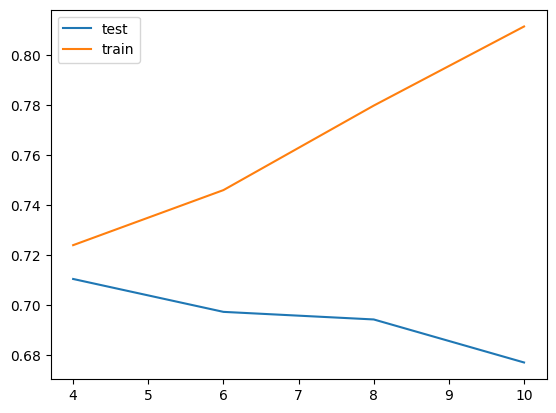

In [48]:
plt.plot(depths, test_accs, label='test')
plt.plot(depths, train_accs, label='train')
#plt.xscale('log')
plt.legend()
plt.show()

# Retrain Models under Dataset Shift - Synthetic Noise

In [13]:
# Standard deviations for synthetic noise
noise_seeds = range(10)
threshold = 0.1

In [16]:
for i, depth in enumerate(tqdm(depths)):
    models = []
    for idx, noise_seed in enumerate(noise_seeds):
        perturb_params = datasets.PerturbParams(args.strategy, threshold,
                                                args.target_indices, args.target_vals,
                                                args.indices_to_change, args.new_vals)
        scaler, scaler_labels = None, None
        train, test = datasets.load_data(args.file_base, args.dataset, scaler,
                                        scaler_labels, noise_seed, perturb_params, noisy_test=False)
        model = tree.DecisionTreeClassifier(max_depth=depth,
                                            min_samples_leaf=min_samples_leaf)
        model = model.fit(train.data, train.labels.to_numpy()[:, 0])
        models.append(model)
    dump(models, output_dir+f'/models_depth{depth}_thresh{threshold}.joblib')

100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


# Compute Explanations

In [17]:
# Compute LIME explanations for one base model
def explain_lime(model, X_test):
    explainer = lime.lime_tabular.LimeTabularExplainer(X, class_names=['0', '1'],
                                                       discretize_continuous=False)
    lime_exps = np.zeros((X_test.shape[0], X_test.shape[1]))
    for idx in range(X_test.shape[0]):
        exp = explainer.explain_instance(X_test[idx], model.predict_proba,
                                        num_features=num_feat, num_samples=5000)
        feature_idxs = [int(i[0]) for i in exp.as_list()]
        lime_values = [i[1] for i in exp.as_list()]
        lime_exps[idx, feature_idxs] = np.array(lime_values)
    return np.array(lime_exps)

### SHAP Explanations

In [34]:
for i, depth in enumerate(tqdm(depths)):
    base = load(output_dir + f'/base_depth{depth}.joblib')
    
    # Compute shap
    explainer = shap.Explainer(base)
    shap_test = explainer(X_test).values#[:, :, 1]

    # Save gradients/explanations
    dump(shap_test, output_dir+f'/base_shap_depth{depth}.joblib')

    # Load models
    models = load(output_dir+f'/models_depth{depth}.joblib')
    
    shap_test_models = []
    for j, threshold in enumerate(thresholds):
        for idx, noise_seed in enumerate(noise_seeds):
            model = models[j*len(noise_seeds) + idx]
            # Compute shap
            explainer = shap.Explainer(model)
            shap_test = explainer(X_test, check_additivity=False).values#"[:, :, 1]
            shap_test_models.append(shap_test)
    dump(shap_test_models, output_dir+f'/models_shap_depth{depth}.joblib')

100%|██████████| 5/5 [01:19<00:00, 15.94s/it]


In [18]:
for i, depth in enumerate(tqdm(depths)):
    base = load(output_dir + f'/base_depth{depth}.joblib')
    
    # Compute shap
    explainer = shap.Explainer(base)
    shap_test = explainer(X_test).values#[:, :, 1]

    # Save gradients/explanations
    dump(shap_test, output_dir+f'/base_shap_depth{depth}_thresh{threshold}.joblib')

    # Load models
    models = load(output_dir+f'/models_depth{depth}_thresh{threshold}.joblib')
    
    shap_test_models = []
    for idx, noise_seed in enumerate(noise_seeds):
        model = models[idx]
        # Compute shap
        explainer = shap.Explainer(model)
        shap_test = explainer(X_test, check_additivity=False).values#"[:, :, 1]
        shap_test_models.append(shap_test)
    dump(shap_test_models, output_dir+f'/models_shap_depth{depth}_thresh{threshold}.joblib')

100%|██████████| 4/4 [00:00<00:00, 36.15it/s]


### LIME Explanations

In [10]:
for i, depth in enumerate(tqdm(depths)):
    base = load(output_dir + f'/base_depth{depth}.joblib')
    
    # Compute lime
    lime_test = explain_lime(base, X_test[:100])

    # Save explanations
    dump(lime_test, output_dir+f'/base_lime_depth{depth}.joblib')

    # Load models
    models = load(output_dir+f'/models_depth{depth}.joblib')
    
    lime_test_models = []
    for j, threshold in enumerate(thresholds):
        for idx, noise_seed in enumerate(noise_seeds):
            model = models[j*len(noise_seeds) + idx]
            # Compute lime
            lime_test = explain_lime(model, X_test[:100])
            lime_test_models.append(lime_test)
    dump(lime_test_models, output_dir+f'/models_lime_depth{depth}.joblib')

100%|██████████| 5/5 [03:08<00:00, 37.80s/it]


In [19]:
for i, depth in enumerate(tqdm(depths)):
    base = load(output_dir + f'/base_depth{depth}.joblib')
    
    # Compute lime
    lime_test = explain_lime(base, X_test)

    # Save explanations
    dump(lime_test, output_dir+f'/base_lime_depth{depth}_thresh{threshold}.joblib')

    # Load models
    models = load(output_dir+f'/models_depth{depth}_thresh{threshold}.joblib')
    
    lime_test_models = []
    for idx, noise_seed in enumerate(noise_seeds):
        model = models[idx]
        # Compute lime
        lime_test = explain_lime(model, X_test)
        lime_test_models.append(lime_test)
    dump(lime_test_models, output_dir+f'/models_lime_depth{depth}_thresh{threshold}.joblib')

100%|██████████| 4/4 [00:36<00:00,  9.17s/it]


# Compute Top-K Explanation Stability

In [21]:
from metrics import get_top_k, top_k_sa, top_k_cdc, top_k_ssa

In [22]:
exps = ['shap', 'lime'] #['salience', 'smoothgrad', 'lime_grads', 'kernel_shap']
mets = [top_k_sa, top_k_cdc, top_k_ssa] #
met_names = ['sa', 'cdc', 'ssa']
ks = [5]  # values of k in top-k

In [26]:
for exp in exps:
    print(f'Computing {exp.title()} Metrics...')
    for m, met in enumerate(tqdm(mets)):
        for k in ks:
            exp_met_ks = np.zeros((len(depths), len(noise_seeds)))
            for i, depth in enumerate(depths):
                # g1 represents base model gradients
                g1 = load(output_dir+f'/base_{exp}_depth{depth}_thresh{threshold}.joblib')
                g1 = g1[:, :, 1] if exp=='shap' else g1
                s1 = np.sign(g1)
                tk1 = get_top_k(k, g1)

                # Load explanations from models
                exp_test_models = load(output_dir+f'/models_{exp}_depth{depth}_thresh{threshold}.joblib')

                #for j, threshold in enumerate(thresholds):
                for idx, noise_seed in enumerate(noise_seeds):
                    # g2 represents shifted model explanations
                    g2 = exp_test_models[idx]
                    g2 = g2[:, :, 1] if exp=='shap' else g2
                    s2 = np.sign(g2)
                    tk2 = get_top_k(k, g2)
                    exp_met_ks[i,idx] = met(k, tk1, tk2, s1, s2)

            # save exp-met-k combo
            dump(exp_met_ks, output_dir+f'/{exp}_top_{k}_{met_names[m]}_thresh{threshold}.npy')

Computing Shap Metrics...


100%|██████████| 3/3 [00:00<00:00, 32.25it/s]


Computing Lime Metrics...


100%|██████████| 3/3 [00:00<00:00, 35.77it/s]


# Quick Results

In [27]:
shap_sa = load(output_dir+f'/shap_top_5_sa_thresh{threshold}.npy')
q = np.quantile(shap_sa, [0.25, 0.5, 0.75], axis=1)
q[0], (q[2]+q[0])/2, q[2], (q[2]-q[0])/2

(array([0.725 , 0.6505, 0.5495, 0.4975]),
 array([0.77525, 0.67425, 0.584  , 0.52325]),
 array([0.8255, 0.698 , 0.6185, 0.549 ]),
 array([0.05025, 0.02375, 0.0345 , 0.02575]))

In [28]:
lime_sa = load(output_dir+f'/lime_top_5_sa_thresh{threshold}.npy')
q = np.quantile(lime_sa, [0.25, 0.5, 0.75], axis=1)
q[0], (q[2]+q[0])/2, q[2], (q[2]-q[0])/2

(array([0.78  , 0.7335, 0.6315, 0.557 ]),
 array([0.80625, 0.76375, 0.6885 , 0.6205 ]),
 array([0.8325, 0.794 , 0.7455, 0.684 ]),
 array([0.02625, 0.03025, 0.057  , 0.0635 ]))

In [40]:
X_test.shape, y_test.shape

((1975, 23), (1975, 1))

In [45]:
# Load models
model_accs = []
for i, depth in enumerate(depths):
    models = load(output_dir+f'/models_depth{depth}_thresh{threshold}.joblib')
    model_acc = np.zeros(len(noise_seeds))
    for idx, noise_seed in enumerate(noise_seeds):
        model = models[idx]
        model_acc[idx] = (model.predict(X_test)==y_test).mean()
    model_accs.append(model_acc)
q = np.quantile(np.array(model_accs), [0.25, 0.5, 0.75], axis=1)
100*q[0], 100*(q[2]-q[0])/2

(array([71.25316456, 70.91139241, 69.34177215, 67.93670886]),
 array([0.2721519 , 0.26582278, 0.24683544, 0.6835443 ]))

In [46]:
q = np.quantile(np.array(model_accs), [0.25, 0.5, 0.75], axis=1)
100*q[0], 100*(q[2]-q[0])/2

(array([71.25316456, 70.91139241, 69.34177215, 67.93670886]),
 array([0.2721519 , 0.26582278, 0.24683544, 0.6835443 ]))

# Plot Explanation Stability

In [14]:
exps = ['shap', 'lime']
met_names = ['sa', 'cdc', 'ssa']
met_names_full = ['Sign-Agreement (SA)',
                  'Consistent-Direction-of-Contribution (CDC)',
                  'Signed-Set-Agreement (SSA)']
k=5

### All Similarity Metrics

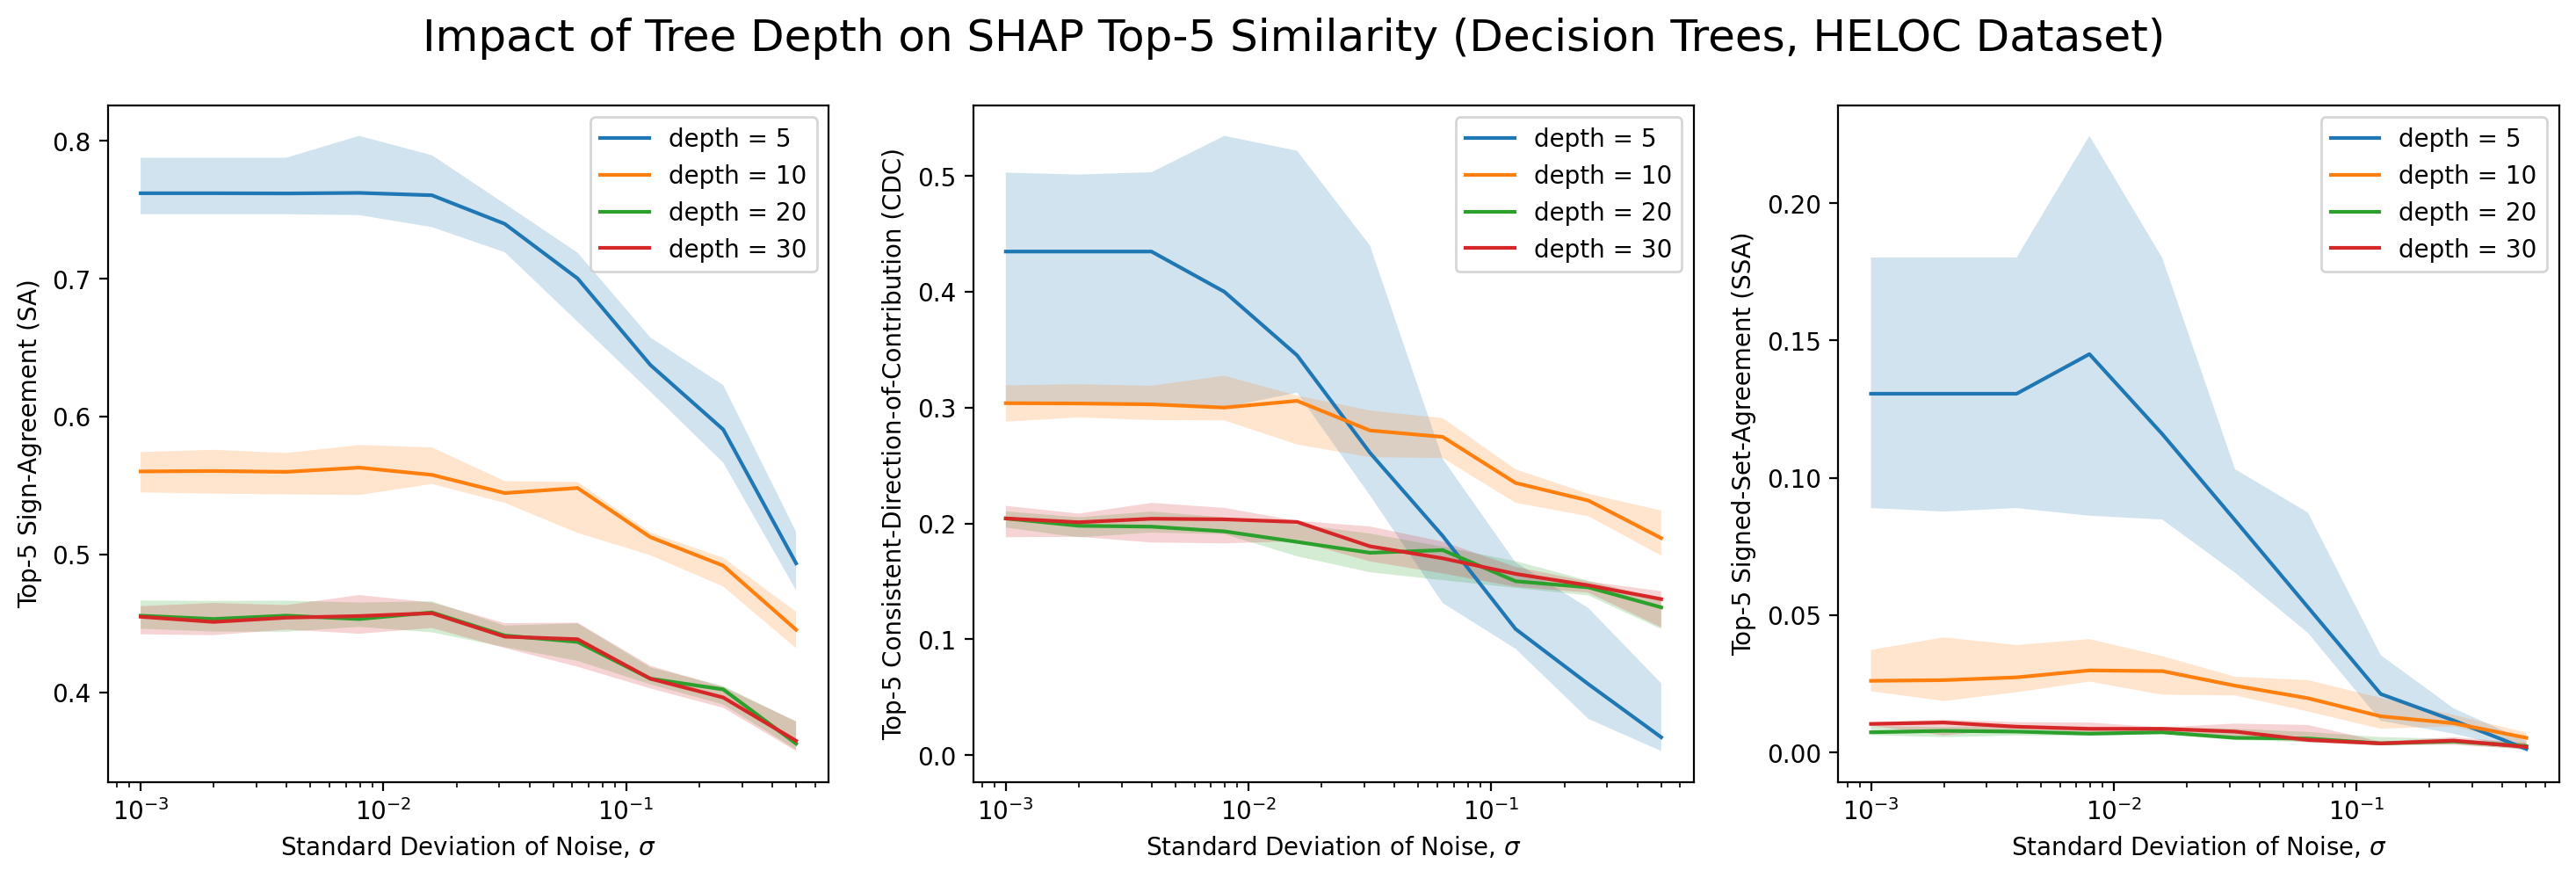

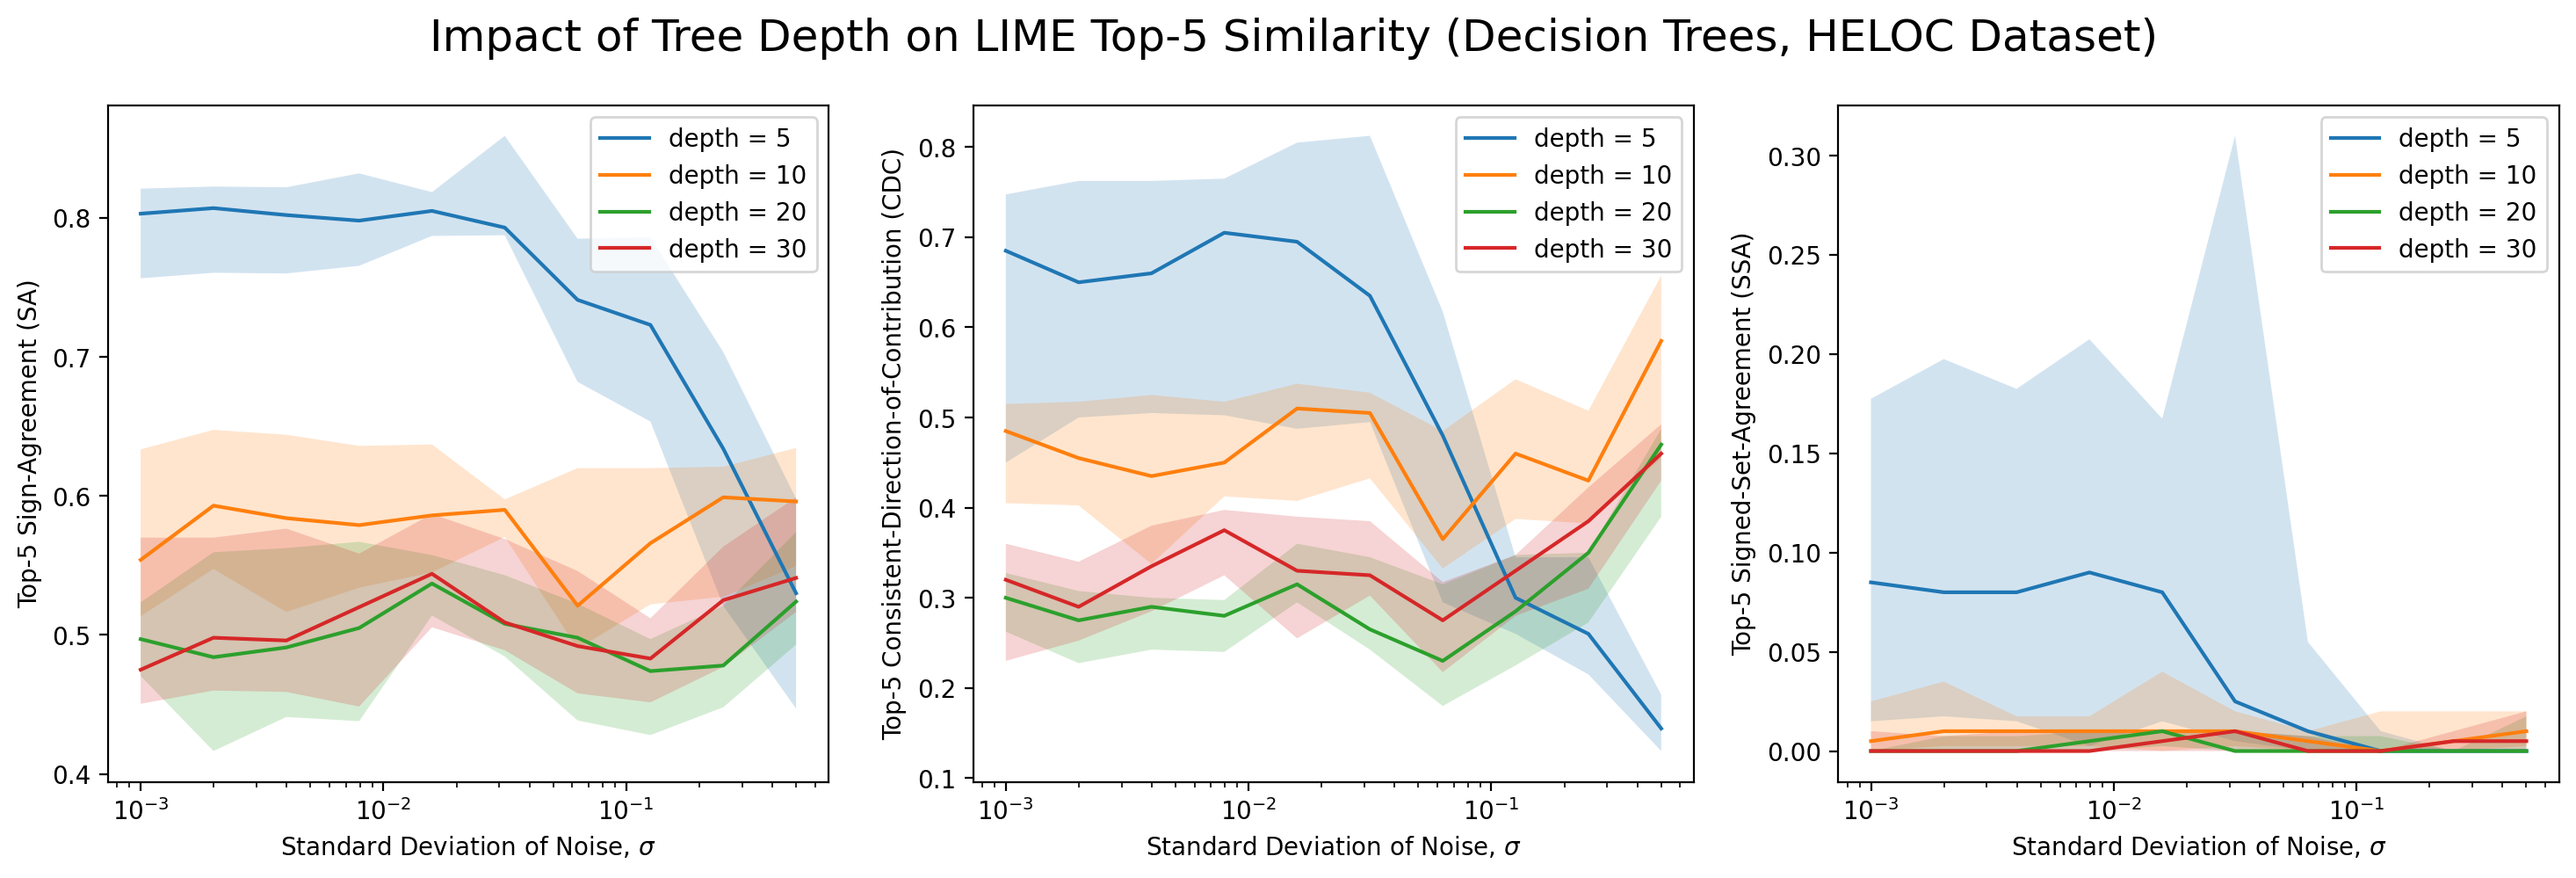

In [17]:
for exp in exps:
    fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=200)
    for i, met in enumerate(met_names):
        topk = load(output_dir+f'/{exp}_top_{k}_{met}.npy')
        ax[i].set_ylabel(f'Top-{k} {met_names_full[i]}')
        ax[i].set_xlabel('Standard Deviation of Noise, $\sigma$')
        for j, depth in enumerate(depths[1:]):
            q = np.quantile(topk[j+1], [0.25, 0.5, 0.75], axis=1)
            ax[i].plot(thresholds, q[1], label=f'depth = {depth}')
            ax[i].fill_between(thresholds, q[0], q[2], alpha=0.2)
        ax[i].set_xscale('log')
        ax[i].legend()
    plt.suptitle(f'Impact of Tree Depth on {exp.upper()} Top-5 Similarity (Decision Trees, HELOC Dataset)', fontsize=18)
    plt.show()

### Single Similarity Metric

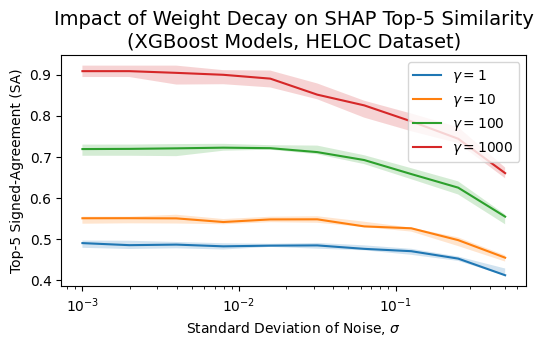

In [133]:
topk = load(output_dir+f'/shap_top_{k}_sa_lambda.npy')
plt.figure(figsize=(6,3), dpi=100)
plt.title('Impact of Weight Decay on SHAP Top-5 Similarity\n(XGBoost Models, HELOC Dataset)', fontsize=14)
plt.ylabel('Top-5 Signed-Agreement (SA)')
plt.xlabel('Standard Deviation of Noise, $\sigma$')
for i, depth in enumerate(depths):
    q = np.quantile(topk[i], [0.25, 0.5, 0.75], axis=1)
    plt.plot(thresholds, q[1], label=f'depth = {depth}')
    plt.fill_between(thresholds, q[0], q[2], alpha=0.2)
plt.xscale('log')
plt.legend()
plt.show()

### Test Accuracy

In [43]:
# Load models
model_accs = []
for i, depth in enumerate(depths):
    models = load(output_dir+f'/models_depth{depth}.joblib')
    model_acc = np.zeros((len(thresholds), len(noise_seeds)))
    for j, threshold in enumerate(thresholds):
        for idx, noise_seed in enumerate(noise_seeds):
            model = models[j*len(noise_seeds) + idx]
            model_acc[j,idx] = (model.predict(X_test)==y_test).mean()
    model_accs.append(model_acc)

NameError: name 'thresholds' is not defined

IndexError: list index out of range

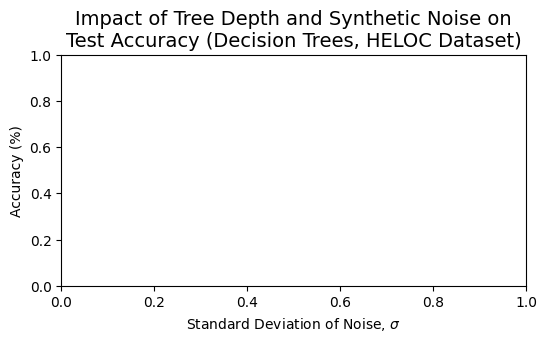

In [44]:
plt.figure(figsize=(6,3), dpi=100)
plt.title('Impact of Tree Depth and Synthetic Noise on\nTest Accuracy (Decision Trees, HELOC Dataset)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.xlabel('Standard Deviation of Noise, $\sigma$')
for i, depth in enumerate(depths[1:]):
    q = np.quantile(model_accs[i+1], [0.25, 0.5, 0.75], axis=1)*100
    plt.plot(thresholds, q[1], label=f'depth = {depth}')
    plt.fill_between(thresholds, q[0], q[2], alpha=0.2)
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()